In [1]:
%%capture state
from __future__ import division
from __future__ import print_function

import sys, os
sys.path.append('../')

import tensorflow as tf
import numpy as np

from models.neural_network import NeuralNetwork
from models.cnn import CNN

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#Seed used for all calculations of training and test point indices 
SEED = 14

In [2]:
## Visualization of samples
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(image):
    plt.figure(figsize=(1, 1))
    if image.shape[-1] == 1:
        # image is in black and white
        image = image[:, :, 0]
        plt.imshow(image, cmap='Greys')
    else:
        # image is in color
        plt.imshow(image)
    plt.axis('off')
    plt.show()

#Normalize rows of a given matrix
def normalize(matrix):
    matrix_nm = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        matrix_nm[i] = matrix[i]/np.linalg.norm(matrix[i]) 
    return matrix_nm

In [3]:
input_shape = (32, 32,3)
num_classes = 2
eps =0.1

In [4]:
#Load model from disk
model_name = 'CIFAR2'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='cifar2')
print (model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 150
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)   

16797378
Loaded model from disk


In [5]:
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

In [6]:
num_test_samples_per_class = 10
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
noisy_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='Noisy', eps=eps)
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM', eps=eps)
bim_a_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-A', iterations=10, eps=eps)
bim_b_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-B', iterations=10, eps=eps)
cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='CW', targeted=False, eps=eps)
df_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='DF')
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='JSMA')

/root/notebook/cleverhans/cleverhans/src/cleverhans/cleverhans/utils_keras.py:144: UserWarning: Please update your version to keras >= 2.1.3; support for earlier keras versions will be dropped on 2018-07-22
  "Please update your version to keras >= 2.1.3; "


In [7]:
#Whitebox CW Attack
#First get guide images
guide_indices = list()
np.random.seed(SEED)
#Generate guide images for modified CW attacks
for idx in test_indices:
    label = np.argmax(model.test_labels[idx])
    #Add 1 to the label mod 10 to get a target label
    mod_label = (label + 1) % num_classes
    #Get a test point with the target label
    guide_imgs_indices = np.where(model.train_labels[:,mod_label] == 1)[0]
    #Choose a guide image
    guide_img_idx = np.random.choice(guide_imgs_indices, 1)[0]
    guide_indices.append(guide_img_idx)


#1 Phase Attack
p1_cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=eps)

#2 Phase Attack
#Phase 1: Generate targeted adversarial images
tar_cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, use_cos_norm_reg=False, eps=eps)
#Phase 2: Optimize for higher cosine sim and smaller norm of gradient vector
p2_cw_data = model.generate_perturbed_data(tar_cw_data, model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=eps)

Loss: 1458.72070, Cos: -1.00000, Norm: 131.72089
Loss: 1188.99048, Cos: -1.00000, Norm: 109.80305
Loss: 885.07617, Cos: -1.00000, Norm: 83.25173
Loss: 53.78639, Cos: -1.00000, Norm: 1.11991
Loss: 58.32988, Cos: -1.00000, Norm: 0.10698
Loss: 71.98215, Cos: -1.00000, Norm: 0.01976
Loss: 85.26105, Cos: -1.00000, Norm: 0.00550
Loss: 97.07375, Cos: -1.00000, Norm: 0.00188
Loss: 107.14812, Cos: -1.00000, Norm: 0.00077
Loss: 115.43658, Cos: -1.00000, Norm: 0.00036
Loss: 121.99780, Cos: -1.00000, Norm: 0.00020
Loss: 126.94440, Cos: -1.00000, Norm: 0.00011
Loss: 130.41597, Cos: -1.00000, Norm: 0.00008
Loss: 132.56268, Cos: -1.00000, Norm: 0.00006
Loss: 133.53622, Cos: -1.00000, Norm: 0.00004
Loss: 133.48413, Cos: -1.00000, Norm: 0.00003
Loss: 132.54636, Cos: -1.00000, Norm: 0.00003
Loss: 130.85400, Cos: -1.00000, Norm: 0.00002
Loss: 128.52798, Cos: -1.00000, Norm: 0.00002
Loss: 125.67899, Cos: -1.00000, Norm: 0.00002
Loss: 122.40738, Cos: -1.00000, Norm: 0.00002
Loss: 1531.66443, Cos: -0.93996,

Loss: 34.02982, Cos: -0.80386, Norm: 0.00080
Loss: 32.12006, Cos: -0.80633, Norm: 0.00128
Loss: 30.33052, Cos: -0.80712, Norm: 0.00205
Loss: 28.66307, Cos: -0.80683, Norm: 0.00328
Loss: 27.15809, Cos: -0.80984, Norm: 0.00520
Loss: 25.75751, Cos: -0.81066, Norm: 0.00814
Loss: 24.48762, Cos: -0.81164, Norm: 0.01302
Loss: 23.36156, Cos: -0.81422, Norm: 0.02033
Loss: 22.38403, Cos: -0.81865, Norm: 0.03082
Loss: 21.50856, Cos: -0.82004, Norm: 0.04519
Loss: 20.76455, Cos: -0.81927, Norm: 0.06575
Loss: 20.13887, Cos: -0.82081, Norm: 0.08662
Loss: 19.58381, Cos: -0.82075, Norm: 0.10656
Loss: 19.08274, Cos: -0.82525, Norm: 0.11694
Loss: 18.46803, Cos: -0.82495, Norm: 0.10967
Loss: 17.90714, Cos: -0.82344, Norm: 0.09857
Loss: 17.41795, Cos: -0.82178, Norm: 0.08586
Loss: 16.98612, Cos: -0.81907, Norm: 0.07323
Loss: 16.63302, Cos: -0.81665, Norm: 0.06410
Loss: 16.31693, Cos: -0.81368, Norm: 0.05729
Loss: 16.05044, Cos: -0.81294, Norm: 0.05293
Loss: 15.80172, Cos: -0.81195, Norm: 0.05123
Loss: 15.5

Loss: 949.21362, Cos: -1.00000, Norm: 91.86739
Loss: 38.56627, Cos: -1.00000, Norm: 0.44727
Loss: 42.82376, Cos: -1.00000, Norm: 0.03983
Loss: 51.75833, Cos: -1.00000, Norm: 0.00743
Loss: 61.08530, Cos: -1.00000, Norm: 0.00204
Loss: 70.13612, Cos: -1.00000, Norm: 0.00075
Loss: 78.63753, Cos: -1.00000, Norm: 0.00033
Loss: 86.45752, Cos: -1.00000, Norm: 0.00018
Loss: 93.53841, Cos: -1.00000, Norm: 0.00011
Loss: 99.86669, Cos: -1.00000, Norm: 0.00007
Loss: 105.45596, Cos: -1.00000, Norm: 0.00005
Loss: 110.33582, Cos: -1.00000, Norm: 0.00003
Loss: 114.54536, Cos: -1.00000, Norm: 0.00003
Loss: 118.12830, Cos: -1.00000, Norm: 0.00002
Loss: 121.13042, Cos: -1.00000, Norm: 0.00002
Loss: 123.59718, Cos: -1.00000, Norm: 0.00002
Loss: 125.57296, Cos: -1.00000, Norm: 0.00002
Loss: 127.10022, Cos: -1.00000, Norm: 0.00002
Loss: 128.21912, Cos: -1.00000, Norm: 0.00002
Loss: 1677.34497, Cos: -0.99646, Norm: 157.63048
Loss: 1324.09021, Cos: -0.99123, Norm: 126.97853
Loss: 40.83208, Cos: -0.99126, Norm:

Loss: 16.68980, Cos: -0.98556, Norm: 0.00410
Loss: 16.42190, Cos: -0.98521, Norm: 0.00553
Loss: 16.17432, Cos: -0.98502, Norm: 0.00740
Loss: 15.94412, Cos: -0.98493, Norm: 0.00952
Loss: 15.73239, Cos: -0.98500, Norm: 0.01198
Loss: 15.53769, Cos: -0.98509, Norm: 0.01483
Loss: 15.36096, Cos: -0.98486, Norm: 0.01852
Loss: 15.19942, Cos: -0.98499, Norm: 0.02211
Loss: 15.05018, Cos: -0.98496, Norm: 0.02583
Loss: 14.91580, Cos: -0.98491, Norm: 0.02979
Loss: 14.78879, Cos: -0.98491, Norm: 0.03314
Loss: 14.66971, Cos: -0.98478, Norm: 0.03612
Loss: 14.55142, Cos: -0.98479, Norm: 0.03771
Loss: 14.44490, Cos: -0.98460, Norm: 0.03936
Loss: 14.33518, Cos: -0.98456, Norm: 0.03925
Loss: 14.22852, Cos: -0.98457, Norm: 0.03816
Loss: 14.12304, Cos: -0.98476, Norm: 0.03593
Loss: 14.02809, Cos: -0.98483, Norm: 0.03408
Loss: 13.94167, Cos: -0.98472, Norm: 0.03264
Loss: 13.86209, Cos: -0.98472, Norm: 0.03136
Loss: 13.78625, Cos: -0.98468, Norm: 0.03020
Loss: 13.71477, Cos: -0.98466, Norm: 0.02926
Loss: 13.6

Loss: 33.20663, Cos: -0.99751, Norm: 0.00006
Loss: 37.47746, Cos: -0.99749, Norm: 0.00003
Loss: 41.18831, Cos: -0.99743, Norm: 0.00002
Loss: 44.34238, Cos: -0.99739, Norm: 0.00001
Loss: 46.96375, Cos: -0.99738, Norm: 0.00000
Loss: 49.08712, Cos: -0.99737, Norm: 0.00000
Loss: 50.75214, Cos: -0.99737, Norm: 0.00000
Loss: 51.99974, Cos: -0.99736, Norm: 0.00000
Loss: 52.87098, Cos: -0.99734, Norm: 0.00000
Loss: 53.40705, Cos: -0.99735, Norm: 0.00000
Loss: 53.64635, Cos: -0.99733, Norm: 0.00000
Loss: 53.62678, Cos: -0.99733, Norm: 0.00000
Loss: 53.38234, Cos: -0.99731, Norm: 0.00000
Loss: 52.94543, Cos: -0.99730, Norm: 0.00000
Loss: 52.34513, Cos: -0.99729, Norm: 0.00000
Loss: 51.60781, Cos: -0.99731, Norm: 0.00000
Loss: 1594.84204, Cos: -1.00000, Norm: 153.17744
Loss: 27.88204, Cos: -1.00000, Norm: 1.25887
Loss: 24.98216, Cos: -1.00000, Norm: 0.00080
Loss: 35.17323, Cos: -1.00000, Norm: 0.00002
Loss: 44.02499, Cos: -1.00000, Norm: 0.00000
Loss: 50.91724, Cos: -1.00000, Norm: 0.00000
Loss: 

Loss: 12.19339, Cos: -0.99197, Norm: 0.02920
Loss: 12.16299, Cos: -0.99194, Norm: 0.02926
Loss: 12.13535, Cos: -0.99192, Norm: 0.02948
Loss: 12.11113, Cos: -0.99196, Norm: 0.02982
Loss: 12.08829, Cos: -0.99194, Norm: 0.03013
Loss: 12.06859, Cos: -0.99189, Norm: 0.03062
Loss: 12.05105, Cos: -0.99175, Norm: 0.03123
Loss: 12.03338, Cos: -0.99170, Norm: 0.03149
Loss: 12.01791, Cos: -0.99179, Norm: 0.03156
Loss: 12.00332, Cos: -0.99179, Norm: 0.03158
Loss: 11.99022, Cos: -0.99188, Norm: 0.03141
Loss: 11.97764, Cos: -0.99187, Norm: 0.03118
Loss: 11.96620, Cos: -0.99179, Norm: 0.03092
Loss: 11.95643, Cos: -0.99175, Norm: 0.03066
Loss: 11.94655, Cos: -0.99169, Norm: 0.03033
Loss: 11.93784, Cos: -0.99170, Norm: 0.03004
Loss: 11.92988, Cos: -0.99168, Norm: 0.02993
Loss: 11.92303, Cos: -0.99171, Norm: 0.02993
Loss: 11.91607, Cos: -0.99172, Norm: 0.03001
Loss: 11.91004, Cos: -0.99175, Norm: 0.03025
Loss: 11.90504, Cos: -0.99175, Norm: 0.03063
Loss: 11.89984, Cos: -0.99167, Norm: 0.03098
Loss: 11.8

Loss: 31.68462, Cos: -0.78177, Norm: 0.00001
Loss: 40.07159, Cos: -0.77936, Norm: 0.00000
Loss: 47.27768, Cos: -0.77827, Norm: 0.00000
Loss: 53.21722, Cos: -0.77856, Norm: 0.00000
Loss: 57.92243, Cos: -0.77946, Norm: 0.00000
Loss: 61.48300, Cos: -0.78019, Norm: 0.00000
Loss: 64.01147, Cos: -0.78024, Norm: 0.00000
Loss: 65.63757, Cos: -0.78044, Norm: 0.00000
Loss: 66.46288, Cos: -0.77897, Norm: 0.00000
Loss: 66.63987, Cos: -0.77939, Norm: 0.00000
Loss: 66.25687, Cos: -0.77944, Norm: 0.00000
Loss: 65.41640, Cos: -0.77917, Norm: 0.00000
Loss: 64.21535, Cos: -0.77926, Norm: 0.00000
Loss: 62.73157, Cos: -0.77964, Norm: 0.00000
Loss: 61.03731, Cos: -0.78078, Norm: 0.00000
Loss: 59.17231, Cos: -0.78083, Norm: 0.00000
Loss: 57.20203, Cos: -0.78148, Norm: 0.00000
Loss: 55.14591, Cos: -0.78070, Norm: 0.00000
Loss: 53.06673, Cos: -0.78161, Norm: 0.00000
Loss: 50.95684, Cos: -0.78091, Norm: 0.00000
Loss: 48.87556, Cos: -0.78236, Norm: 0.00000
Loss: 46.82114, Cos: -0.78392, Norm: 0.00000
Loss: 44.8

Loss: 2.34201, Cos: -0.00000, Norm: 0.00644
Loss: 2.27721, Cos: -0.00000, Norm: 0.00698
Loss: 209.49713, Cos: -1.00000, Norm: 19.94971
Loss: 13.24575, Cos: -1.00000, Norm: 0.00269
Loss: 18.83954, Cos: -1.00000, Norm: 0.00004
Loss: 24.89500, Cos: -1.00000, Norm: 0.00000
Loss: 30.78900, Cos: -1.00000, Norm: 0.00000
Loss: 36.27222, Cos: -1.00000, Norm: 0.00000
Loss: 41.23767, Cos: -1.00000, Norm: 0.00000
Loss: 45.64492, Cos: -1.00000, Norm: 0.00000
Loss: 49.48772, Cos: -1.00000, Norm: 0.00000
Loss: 52.77986, Cos: -1.00000, Norm: 0.00000
Loss: 55.54803, Cos: -1.00000, Norm: 0.00000
Loss: 57.82703, Cos: -1.00000, Norm: 0.00000
Loss: 59.65601, Cos: -1.00000, Norm: 0.00000
Loss: 61.07511, Cos: -1.00000, Norm: 0.00000
Loss: 62.12329, Cos: -1.00000, Norm: 0.00000
Loss: 62.83748, Cos: -1.00000, Norm: 0.00000
Loss: 63.25267, Cos: -1.00000, Norm: 0.00000
Loss: 63.40236, Cos: -1.00000, Norm: 0.00000
Loss: 63.31844, Cos: -1.00000, Norm: 0.00000
Loss: 63.03095, Cos: -1.00000, Norm: 0.00000
Loss: 62.5

Loss: 49.91808, Cos: -0.96956, Norm: 0.00000
Loss: 55.98499, Cos: -0.97062, Norm: 0.00000
Loss: 61.41741, Cos: -0.97173, Norm: 0.00000
Loss: 66.21332, Cos: -0.97227, Norm: 0.00000
Loss: 70.39811, Cos: -0.97281, Norm: 0.00000
Loss: 74.00174, Cos: -0.97347, Norm: 0.00000
Loss: 77.04852, Cos: -0.97335, Norm: 0.00000
Loss: 79.58746, Cos: -0.97370, Norm: 0.00000
Loss: 81.65172, Cos: -0.97401, Norm: 0.00000
Loss: 83.27688, Cos: -0.97392, Norm: 0.00000
Loss: 84.50775, Cos: -0.97403, Norm: 0.00000
Loss: 85.37949, Cos: -0.97408, Norm: 0.00000
Loss: 85.93125, Cos: -0.97436, Norm: 0.00000
Loss: 86.19360, Cos: -0.97453, Norm: 0.00000
Loss: 86.19766, Cos: -0.97452, Norm: 0.00000
Loss: 980.45508, Cos: -0.98654, Norm: 97.05898
Loss: 14.48090, Cos: -0.93683, Norm: 0.00018
Loss: 23.32061, Cos: -0.91604, Norm: 0.00000
Loss: 33.11406, Cos: -0.90294, Norm: 0.00000
Loss: 42.92705, Cos: -0.89630, Norm: 0.00000
Loss: 52.31857, Cos: -0.89055, Norm: 0.00000
Loss: 61.10837, Cos: -0.88524, Norm: 0.00000
Loss: 69

Loss: 101.57194, Cos: -1.00000, Norm: 0.00000
Loss: 104.23235, Cos: -1.00000, Norm: 0.00000
Loss: 106.44630, Cos: -1.00000, Norm: 0.00000
Loss: 108.25124, Cos: -1.00000, Norm: 0.00000
Loss: 109.68304, Cos: -1.00000, Norm: 0.00000
Loss: 110.77566, Cos: -1.00000, Norm: 0.00000
Loss: 111.56084, Cos: -1.00000, Norm: 0.00000
Loss: 139.28949, Cos: -0.99884, Norm: 12.93011
Loss: 12.79026, Cos: -0.99824, Norm: 0.00912
Loss: 17.43695, Cos: -0.99786, Norm: 0.00031
Loss: 22.49689, Cos: -0.99764, Norm: 0.00004
Loss: 27.36988, Cos: -0.99751, Norm: 0.00001
Loss: 31.84125, Cos: -0.99745, Norm: 0.00000
Loss: 35.82189, Cos: -0.99742, Norm: 0.00000
Loss: 39.28142, Cos: -0.99741, Norm: 0.00000
Loss: 42.22026, Cos: -0.99734, Norm: 0.00000
Loss: 44.65820, Cos: -0.99730, Norm: 0.00000
Loss: 46.62460, Cos: -0.99726, Norm: 0.00000
Loss: 48.15528, Cos: -0.99723, Norm: 0.00000
Loss: 49.28928, Cos: -0.99721, Norm: 0.00000
Loss: 50.06651, Cos: -0.99721, Norm: 0.00000
Loss: 50.52664, Cos: -0.99722, Norm: 0.00000
L

In [8]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='cifar2')
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


In [9]:
print (model.model.evaluate(reg_data,model.test_labels[test_indices]))
print (model.model.evaluate(noisy_data,model.test_labels[test_indices]))
print (model.model.evaluate(fgsm_data,model.test_labels[test_indices]))
print (model.model.evaluate(bim_a_data,model.test_labels[test_indices]))
print (model.model.evaluate(bim_b_data,model.test_labels[test_indices]))
print (model.model.evaluate(cw_data,model.test_labels[test_indices]))
print (model.model.evaluate(df_data,model.test_labels[test_indices]))
print (model.model.evaluate(jsma_data,model.test_labels[test_indices]))
print (model.model.evaluate(p1_cw_data,model.test_labels[test_indices]))
print (model.model.evaluate(p2_cw_data,model.test_labels[test_indices]))

20/20 [==============================] - 0s 2ms/step
[0.05752403661608696, 1.0]
20/20 [==============================] - 0s 443us/step
[0.061207447201013565, 1.0]
20/20 [==============================] - 0s 438us/step
[11.043676376342773, 0.0]
20/20 [==============================] - 0s 414us/step
[2.0253727436065674, 0.0]
20/20 [==============================] - 0s 466us/step
[14.938718795776367, 0.0]
20/20 [==============================] - 0s 467us/step
[2.6458559036254883, 0.0]
20/20 [==============================] - 0s 434us/step
[1.6898250579833984, 0.0]
20/20 [==============================] - 0s 431us/step
[0.87055999040603638, 0.0]
20/20 [==============================] - 0s 422us/step
[5.413330078125, 0.0]
20/20 [==============================] - 0s 425us/step
[2.6458549499511719, 0.0]


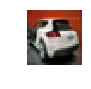

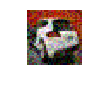

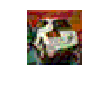

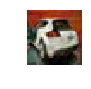

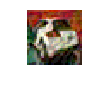

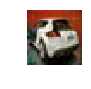

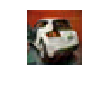

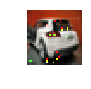

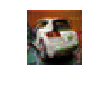

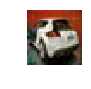

In [10]:
#Lets visualize one sample from each dataset
x_vis = np.random.choice(range(0,num_test_samples), 1)
visualize(reg_data[x_vis].reshape(*input_shape))
visualize(noisy_data[x_vis].reshape(*input_shape))
visualize(fgsm_data[x_vis].reshape(*input_shape))
visualize(bim_a_data[x_vis].reshape(*input_shape))
visualize(bim_b_data[x_vis].reshape(*input_shape))
visualize(cw_data[x_vis].reshape(*input_shape))
visualize(df_data[x_vis].reshape(*input_shape))
visualize(jsma_data[x_vis].reshape(*input_shape))
visualize(p1_cw_data[x_vis].reshape(*input_shape))
visualize(p2_cw_data[x_vis].reshape(*input_shape))

In [11]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
noisy_preds = model.model.predict(noisy_data.reshape(-1,*input_shape))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_a_preds = model.model.predict(bim_a_data.reshape(-1,*input_shape))
bim_b_preds = model.model.predict(bim_b_data.reshape(-1,*input_shape))
cw_preds = model.model.predict(cw_data.reshape(-1,*input_shape))
df_preds = model.model.predict(df_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))
p1_cw_preds = model.model.predict(p1_cw_data.reshape(-1,*input_shape))
p2_cw_preds = model.model.predict(p2_cw_data.reshape(-1,*input_shape))

In [12]:
#Convert preds to labels
reg_labels = np.zeros(reg_preds.shape)
reg_labels[np.arange(num_test_samples),np.argmax(reg_preds, axis=1)] = 1

noisy_labels = np.zeros(noisy_preds.shape)
noisy_labels[np.arange(num_test_samples),np.argmax(noisy_preds, axis=1)] = 1

fgsm_labels = np.zeros(fgsm_preds.shape)
fgsm_labels[np.arange(num_test_samples),np.argmax(fgsm_preds, axis=1)] = 1

bim_a_labels = np.zeros(bim_a_preds.shape)
bim_a_labels[np.arange(num_test_samples),np.argmax(bim_a_preds, axis=1)] = 1

bim_b_labels = np.zeros(bim_b_preds.shape)
bim_b_labels[np.arange(num_test_samples),np.argmax(bim_b_preds, axis=1)] = 1

cw_labels = np.zeros(cw_preds.shape)
cw_labels[np.arange(num_test_samples),np.argmax(cw_preds, axis=1)] = 1

df_labels = np.zeros(df_preds.shape)
df_labels[np.arange(num_test_samples),np.argmax(df_preds, axis=1)] = 1

jsma_labels = np.zeros(jsma_preds.shape)
jsma_labels[np.arange(num_test_samples),np.argmax(jsma_preds, axis=1)] = 1

p1_cw_labels = np.zeros(p1_cw_preds.shape)
p1_cw_labels[np.arange(num_test_samples),np.argmax(p1_cw_preds, axis=1)] = 1

p2_cw_labels = np.zeros(p2_cw_preds.shape)
p2_cw_labels[np.arange(num_test_samples),np.argmax(p2_cw_preds, axis=1)] = 1

In [13]:
#Check preds to ensure adversarial samples were generated correctly
print (np.argmax(reg_preds, axis=1))
print (np.argmax(noisy_preds, axis=1))
print (np.argmax(fgsm_preds, axis=1))
print (np.argmax(bim_a_preds, axis=1))
print (np.argmax(bim_b_preds, axis=1))
print (np.argmax(cw_preds, axis=1))
print (np.argmax(df_preds, axis=1))
print (np.argmax(jsma_preds, axis=1))
print (np.argmax(p1_cw_preds, axis=1))
print (np.argmax(p2_cw_preds, axis=1))

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


In [14]:
#Get gradients for all test points
grads_reg = model.get_gradients_wrt_params(reg_data, reg_labels)
grads_noisy = model.get_gradients_wrt_params(noisy_data, noisy_labels)
grads_fgsm = model.get_gradients_wrt_params(fgsm_data, fgsm_labels)
grads_bim_a = model.get_gradients_wrt_params(bim_a_data, bim_a_labels)
grads_bim_b = model.get_gradients_wrt_params(bim_b_data, bim_b_labels)
grads_cw = model.get_gradients_wrt_params(cw_data, cw_labels)
grads_df = model.get_gradients_wrt_params(df_data, df_labels)
grads_jsma = model.get_gradients_wrt_params(jsma_data, jsma_labels)
grads_p1_cw = model.get_gradients_wrt_params(p1_cw_data, p1_cw_labels)
grads_p2_cw = model.get_gradients_wrt_params(p2_cw_data, p2_cw_labels)

#Get gradients for training points 
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)

In [15]:
grads_reg_nm = normalize(grads_reg)
grads_noisy_nm = normalize(grads_noisy)
grads_fgsm_nm = normalize(grads_fgsm)
grads_bim_a_nm = normalize(grads_bim_a)
grads_bim_b_nm = normalize(grads_bim_b)
grads_cw_nm = normalize(grads_cw)
grads_df_nm = normalize(grads_df)
grads_jsma_nm = normalize(grads_jsma)
grads_p1_cw_nm = normalize(grads_p1_cw)
grads_p2_cw_nm = normalize(grads_p2_cw)
grads_train_nm = normalize(grads_train)

In [16]:
#Get norms 
grads_reg_norms = np.sqrt(np.dot(grads_reg, grads_reg.T)).diagonal()
grads_noisy_norms = np.sqrt(np.dot(grads_noisy, grads_noisy.T)).diagonal()
grads_bim_a_norms = np.sqrt(np.dot(grads_bim_a, grads_bim_b.T)).diagonal()
grads_bim_b_norms = np.sqrt(np.dot(grads_bim_b, grads_bim_b.T)).diagonal()
grads_fgsm_norms = np.sqrt(np.dot(grads_fgsm, grads_fgsm.T)).diagonal()
grads_cw_norms = np.sqrt(np.dot(grads_cw, grads_cw.T)).diagonal()
grads_df_norms = np.sqrt(np.dot(grads_df, grads_df.T)).diagonal()
grads_jsma_norms = np.sqrt(np.dot(grads_jsma, grads_jsma.T)).diagonal()
grads_p1_cw_norms = np.sqrt(np.dot(grads_p1_cw, grads_p1_cw.T)).diagonal()
grads_p2_cw_norms = np.sqrt(np.dot(grads_p2_cw, grads_p2_cw.T)).diagonal()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_lau

In [17]:
#Get cosine similarity matrix
cos_sim_reg = np.dot(grads_reg_nm, grads_train_nm.T)
cos_sim_noisy = np.dot(grads_noisy_nm, grads_train_nm.T)
cos_sim_fgsm = np.dot(grads_fgsm_nm, grads_train_nm.T)
cos_sim_bim_a = np.dot(grads_bim_a_nm, grads_train_nm.T)
cos_sim_bim_b = np.dot(grads_bim_b_nm, grads_train_nm.T)
cos_sim_cw = np.dot(grads_cw_nm, grads_train_nm.T)
cos_sim_df = np.dot(grads_df_nm, grads_train_nm.T)
cos_sim_jsma = np.dot(grads_jsma_nm, grads_train_nm.T)
cos_sim_p1_cw = np.dot(grads_p1_cw_nm, grads_train_nm.T)
cos_sim_p2_cw = np.dot(grads_p2_cw_nm, grads_train_nm.T)

In [37]:
#Separate Using Cos Sim
eta = 0.575

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a[i]) > eta:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b[i]) > eta:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > eta:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > eta:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > eta:
        count+=1.0
        
print ('1 Phase CW:  %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > eta:
        count+=1.0
        
print ('2 Phase CW:  %.4f' % ( count/num_test_samples))



Regular: 0.8500
Noisy:  0.7500
FGSM:  0.3000
BIM-A:  0.6000
BIM-B:  0.3500
CW: 0.6000
DF: 0.5500
JSMA: 0.5000
1 Phase CW:  0.8000
2 Phase CW:  0.6000


In [39]:
#Separate using just norm
gamma = .5

count = 0.0
for i in range(num_test_samples):
    if grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_a_norms[i] < gamma:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_b_norms[i] < gamma:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_df_norms[i] < gamma:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_jsma_norms[i] < gamma:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p1_cw_norms[i] < gamma:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p2_cw_norms[i] < gamma:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))


Regular: 0.8500
Noisy:  0.8000
FGSM:  0.8000
BIM-A:  1.0000
BIM-B:  1.0000
CW: 0.0000
DF: 0.0000
JSMA: 0.0000
1 Phase CW: 0.6000
2 Phase CW: 0.0000


In [40]:
#Use both cos and norm

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta and grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta and grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta and grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a[i]) > eta and grads_bim_a_norms[i] < gamma:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b[i]) > eta and grads_bim_b_norms[i] < gamma:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))
count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta and grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > eta and grads_df_norms[i] < gamma:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > eta and grads_jsma_norms[i] < gamma:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))


count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > eta and grads_p1_cw_norms[i] < gamma:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > eta and grads_p2_cw_norms[i] < gamma:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))


Regular: 0.8000
Noisy:  0.6500
FGSM:  0.1500
BIM-A:  0.6000
BIM-B:  0.3500
CW: 0.0000
DF: 0.0000
JSMA: 0.0000
1 Phase CW: 0.5000
2 Phase CW: 0.0000


In [41]:
def avg_l2_distortion(orig, adv):
    """Get the mean l2 distortion between two orig and adv images"""
    l2_dist = 0.0
    for i in range(orig.shape[0]):
        l2_dist+= np.linalg.norm(orig[i] - adv[i])
    return l2_dist/orig.shape[0]

In [42]:
print (avg_l2_distortion(reg_data,noisy_data))
print (avg_l2_distortion(reg_data, fgsm_data))
print (avg_l2_distortion(reg_data, bim_a_data))
print (avg_l2_distortion(reg_data, bim_b_data))
print (avg_l2_distortion(reg_data, cw_data))
print (avg_l2_distortion(reg_data, df_data))
print (avg_l2_distortion(reg_data, jsma_data))
print (avg_l2_distortion(reg_data, p1_cw_data))
print (avg_l2_distortion(reg_data, p2_cw_data))

5.44044551591
5.45476183891
1.87681806386
4.56858358383
2.20292674899
1.59963759482
4.34062944651
3.22552965879
2.20292316675


In [24]:
count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a[i])> np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))


count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('1 Phase CW:  %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('2 Phase CW:  %.4f' % ( count/num_test_samples))



Noisy:  0.2500
FGSM:  0.0500
BIM-A:  0.1500
BIM-B:  0.1000
CW: 0.2000
DF: 0.1500
JSMA: 0.1500
1 Phase CW:  0.3500
2 Phase CW:  0.2000


In [25]:
count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < grads_reg_norms[i]:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_a_norms[i] < grads_reg_norms[i]:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_b_norms[i] < grads_reg_norms[i]:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_df_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_jsma_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p1_cw_norms[i] <grads_reg_norms[i]:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p2_cw_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))

Noisy:  0.2000
FGSM:  0.5000
BIM-A:  0.4000
BIM-B:  0.8500
CW: 0.0500
DF: 0.0000
JSMA: 0.0000
1 Phase CW: 0.2000
2 Phase CW: 0.0500
